In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


In [2]:
# Load data
df = pd.read_csv('master_csv_0.csv')

# Choose features
imu_features = [
    'accel_x_filtered', 'accel_z_filtered', 'gyro_y_filtered', 'gyro_z_filtered'
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['Segment UID'].unique():
    segment_df = df[df['Segment UID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


In [3]:
import torch
import torch.nn as nn

class IMU2EMG_Transformer(nn.Module):
    def __init__(self, imu_input_dim, d_model=32, nhead=4, num_layers=2, dropout=0.1):
        super(IMU2EMG_Transformer, self).__init__()
        
        # Project IMU input features to d_model dimension
        self.input_fc = nn.Linear(imu_input_dim, d_model)
        
        # Define the transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=64,
            dropout=dropout,
            batch_first=True  # Makes (batch_size, seq_len, d_model)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer: maps from d_model to 1 output
        self.output_fc = nn.Linear(d_model, 1)

    def forward(self, x, src_key_padding_mask=None):
        """
        x: (batch_size, seq_len, imu_input_dim)
        src_key_padding_mask: (batch_size, seq_len), with True indicating PAD tokens
        """
        x = self.input_fc(x)  # (batch_size, seq_len, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)  # (batch_size, seq_len, d_model)
        output = self.output_fc(x)  # (batch_size, seq_len, 1)
        return output


In [4]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [5]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)     # (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)     # (batch_size, max_seq_len, 1)

    # Create padding mask: shape (batch_size, max_seq_len)
    # False where there's real data, True where there's padding
    lengths = torch.tensor([x.shape[0] for x in imu_batch])
    max_len = imu_batch_padded.shape[1]
    pad_mask = torch.arange(max_len).expand(len(lengths), max_len) >= lengths.unsqueeze(1)
    
    return imu_batch_padded, emg_batch_padded, pad_mask


In [6]:
dataset = IMU_EMG_Dataset(imu_segments, emg_segments)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)



In [7]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Instantiate the model
imu_input_dim = 4  # Adjust this to match your IMU features
model = IMU2EMG_Transformer(imu_input_dim, d_model=32, nhead=4, num_layers=2)
model = model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # We'll mask it manually
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50  # Start small, adjust as needed

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for imu_batch, emg_batch, pad_mask in dataloader:
        imu_batch = imu_batch.to(device)  # (batch_size, seq_len, imu_features)
        emg_batch = emg_batch.to(device)  # (batch_size, seq_len, 1)
        pad_mask = pad_mask.to(device)    # (batch_size, seq_len)

        optimizer.zero_grad()

        # Forward pass
        output = model(imu_batch, src_key_padding_mask=pad_mask)  # (batch_size, seq_len, 1)

        # Compute loss (masking the padded positions)
        loss_per_element = criterion(output, emg_batch)  # (batch_size, seq_len, 1)
        mask = (~pad_mask).unsqueeze(-1)                 # Invert mask: True where data, False where padding
        masked_loss = loss_per_element * mask.float()
        loss = masked_loss.sum() / mask.sum()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    loss_history.append(avg_epoch_loss)

print("Training finished!")


Using device: cpu
Epoch [1/50], Loss: 350.7087
Epoch [2/50], Loss: 349.9407
Epoch [3/50], Loss: 350.3859
Epoch [4/50], Loss: 350.3933
Epoch [5/50], Loss: 350.9539
Epoch [6/50], Loss: 349.6962
Epoch [7/50], Loss: 349.2535
Epoch [8/50], Loss: 349.5956
Epoch [9/50], Loss: 350.6137
Epoch [10/50], Loss: 349.1593
Epoch [11/50], Loss: 350.4532
Epoch [12/50], Loss: 350.6746
Epoch [13/50], Loss: 350.2367
Epoch [14/50], Loss: 350.8156
Epoch [15/50], Loss: 349.5169
Epoch [16/50], Loss: 350.9357
Epoch [17/50], Loss: 349.9921
Epoch [18/50], Loss: 350.7528
Epoch [19/50], Loss: 351.1739
Epoch [20/50], Loss: 349.9289
Epoch [21/50], Loss: 349.9256
Epoch [22/50], Loss: 350.1406
Epoch [23/50], Loss: 350.5201
Epoch [24/50], Loss: 350.9580
Epoch [25/50], Loss: 349.8743
Epoch [26/50], Loss: 349.6595
Epoch [27/50], Loss: 350.2761
Epoch [28/50], Loss: 351.3993
Epoch [29/50], Loss: 350.6564
Epoch [30/50], Loss: 350.5518
Epoch [31/50], Loss: 350.9104
Epoch [32/50], Loss: 350.4349
Epoch [33/50], Loss: 351.2102
E

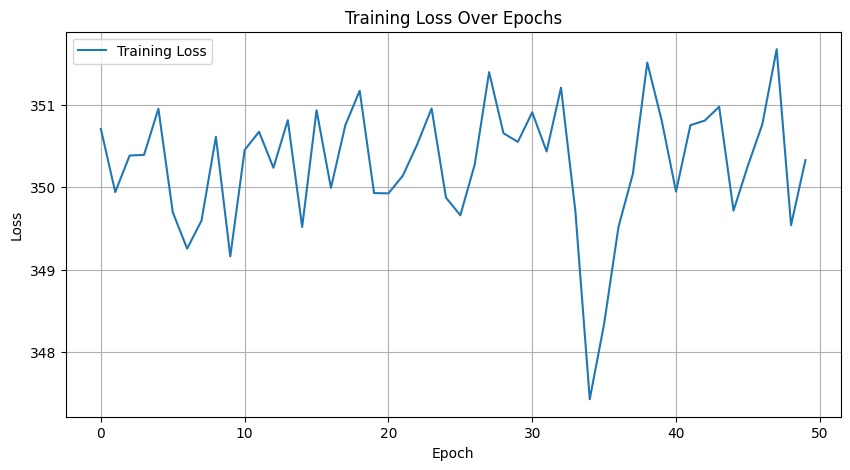

In [8]:
# plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Assuming you have one segment's IMU data:
imu_segment_test = imu_segments[0]  # shape: (seq_len, imu_features)

# Convert to tensor
imu_tensor = torch.tensor(imu_segment_test, dtype=torch.float32)

# Add batch dimension
imu_tensor = imu_tensor.unsqueeze(0)  # shape: (1, seq_len, imu_features)

# Model in eval mode
model.eval()
with torch.no_grad():
    predicted_emg = model(imu_tensor)  # shape: (1, seq_len, 1)

# Remove batch dimension
predicted_emg = predicted_emg.squeeze(0).squeeze(-1).numpy()  # shape: (seq_len,)


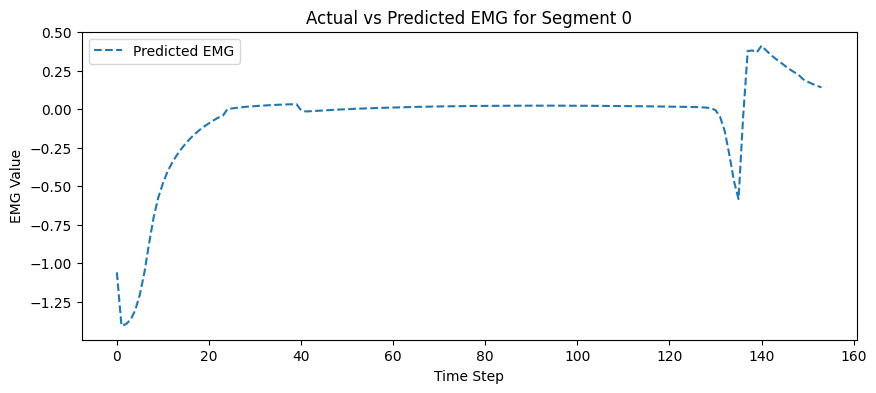

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
# plt.plot(emg_segments[0], label='Actual EMG')
plt.plot(predicted_emg, label='Predicted EMG', linestyle='--')
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("EMG Value")
plt.title("Actual vs Predicted EMG for Segment 0")
plt.show()
